<a href="https://colab.research.google.com/github/babupallam/TensorFlow-Applications-with-Pre-trained-Models/blob/main/04_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
#Install Required Libraries:

!pip install tensorflow opencv-python-headless matplotlib

!pip install google-colab



  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [4]:
#Download Pre-trained YOLOv3 Model and COCO Labels

!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg


--2024-08-21 08:03:48--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  26.1MB/s    in 9.2s    

2024-08-21 08:03:59 (25.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-08-21 08:03:59--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2

In [5]:
# Download COCO Class Names:
# These are the labels that YOLOv3 uses to classify objects

!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names


--2024-08-21 08:04:03--  https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘coco.names’

coco.names          100%[===================>]     625  --.-KB/s    in 0s      

2024-08-21 08:04:03 (24.5 MB/s) - ‘coco.names’ saved [625/625]



In [6]:
#Load Class Names:
#Read the class names from the coco.names file.

def load_class_names(file_name):
    with open(file_name, 'r') as f:
        class_names = f.read().strip().split("\n")
    return class_names

class_names = load_class_names('coco.names')
print(class_names[:10])  # Print first 10 class names


['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light']


In [28]:
#Use OpenCV to load the YOLOv3 model.

import cv2
from google.colab.patches import cv2_imshow # Import the cv2_imshow function

net = cv2.dnn.readNetFromDarknet('yolov3.cfg', 'yolov3.weights')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)


In [8]:
#Define Functions to Process Detections:

def get_outputs_names(net):
    layer_names = net.getLayerNames()
    # Convert the result of getUnconnectedOutLayers to a NumPy array and flatten it
    output_layers = np.array(net.getUnconnectedOutLayers()).flatten()
    return [layer_names[i - 1] for i in output_layers]


def draw_predictions(frame, class_id, confidence, left, top, right, bottom):
    label = f'{class_names[class_id]}: {confidence:.2f}'
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    cv2.putText(frame, label, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)


In [18]:
# Perform Object Detection on an Image:
def detect_objects(frame, net):
    # Create a 4D blob from a frame.
    blob = cv2.dnn.blobFromImage(frame, 1/255, (416, 416), [0, 0, 0], 1, crop=False)
    net.setInput(blob)

    # Run the forward pass to get output of the output layers
    outs = net.forward(get_outputs_names(net))

    frame_height = frame.shape[0]
    frame_width = frame.shape[1]

    confidences = []
    boxes = []
    class_ids = []

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = int(np.argmax(scores))
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * frame_width)
                center_y = int(detection[1] * frame_height)
                width = int(detection[2] * frame_width)
                height = int(detection[3] * frame_height)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])
                class_ids.append(class_id)

    # Perform non-maxima suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Handle the case when NMS returns a scalar (no boxes or only one box)
    if isinstance(indices, np.ndarray):  # Check if indices is an array
        for i in indices.flatten():  # Flatten the array for iteration
            box = boxes[i]
            left, top, width, height = box
            draw_predictions(frame, class_ids[i], confidences[i], left, top, left + width, top + height)
    elif isinstance(indices, int):  # Handle the case of a single index
        box = boxes[indices]
        left, top, width, height = box
        draw_predictions(frame, class_ids[indices], confidences[indices], left, top, left + width, top + height)

    return frame


In [23]:
# Upload an Image:

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')


Saving Screenshot 2024-03-26 142306.png to Screenshot 2024-03-26 142306.png
User uploaded file "Screenshot 2024-03-26 142306.png" with length 934052 bytes


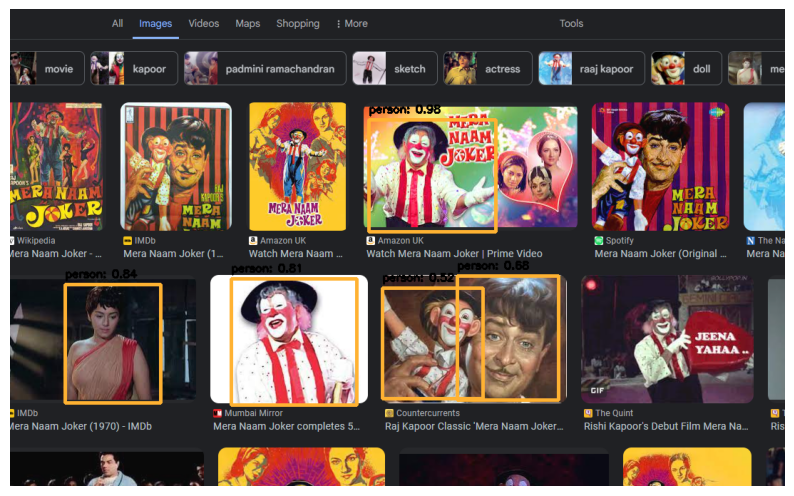

In [24]:
#Load the Image and Perform Detection:


import numpy as np
from matplotlib import pyplot as plt

image_path = list(uploaded.keys())[0]  # Get the uploaded image file name
image = cv2.imread(image_path)

# Convert BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform object detection
detected_image = detect_objects(image, net)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(detected_image)
plt.axis('off')
plt.show()


In [29]:
def detect_objects_in_video(video_path, net):
    cap = cv2.VideoCapture(video_path)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Perform object detection
        detected_frame = detect_objects(frame, net)

        # Display the resulting frame using cv2_imshow
        cv2_imshow(detected_frame) # Use cv2_imshow instead of cv2.imshow

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [30]:
uploaded = files.upload()

video_path = list(uploaded.keys())[0]  # Get the uploaded video file name



Saving Adorable Fluffy Cat Helps Baby Take First Steps!!.mp4 to Adorable Fluffy Cat Helps Baby Take First Steps!! (1).mp4


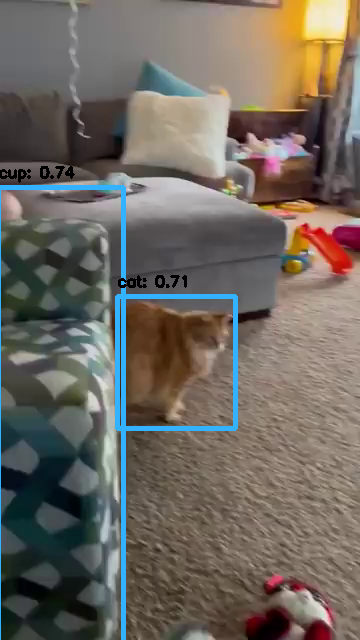

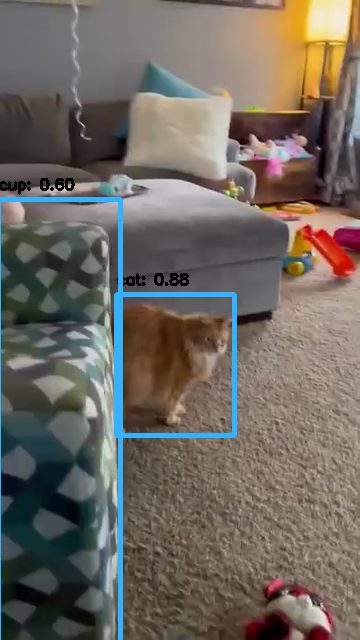

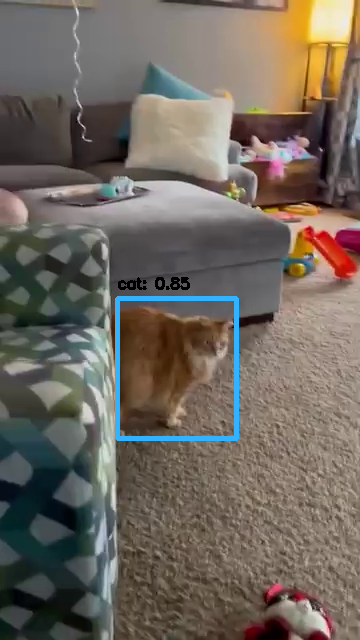

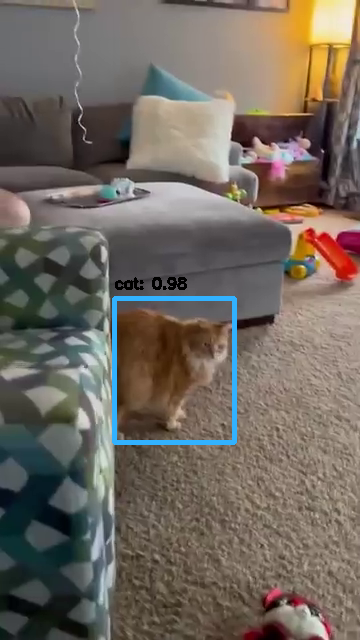

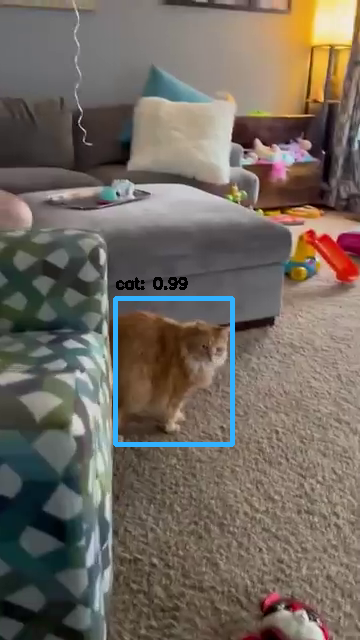

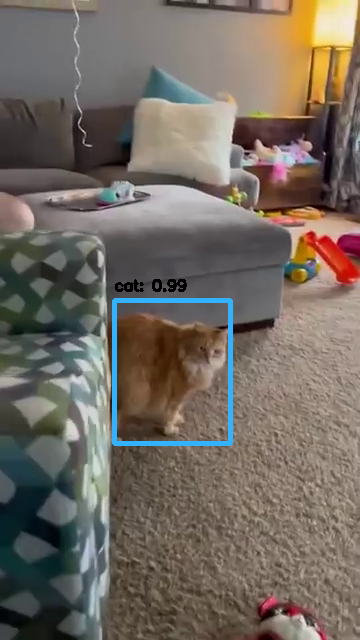

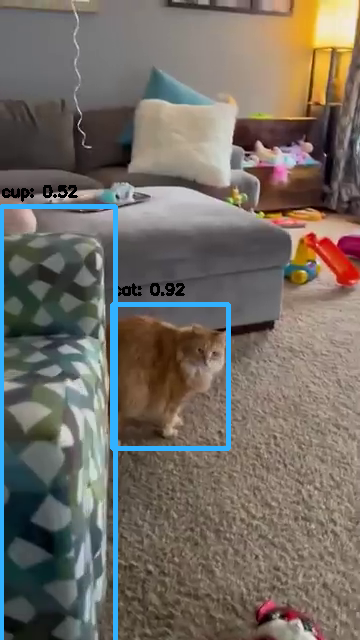

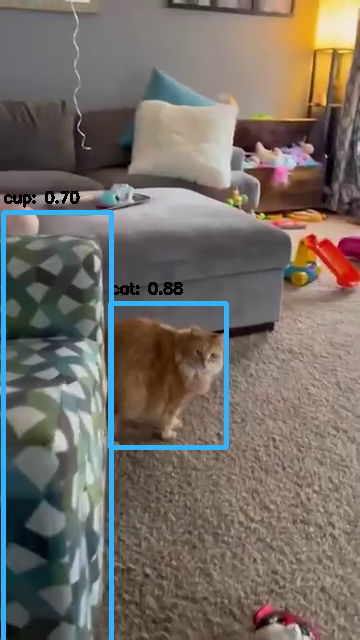

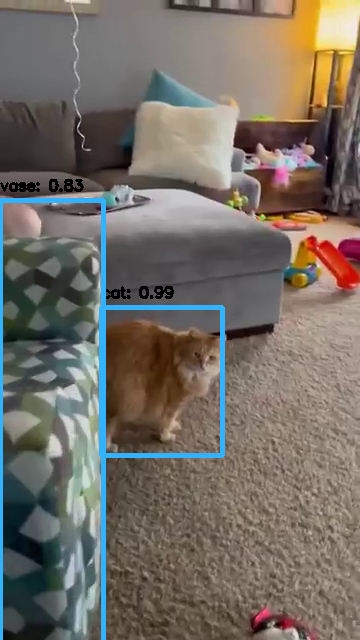

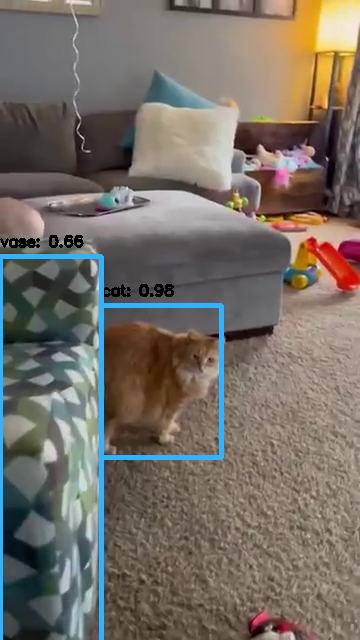

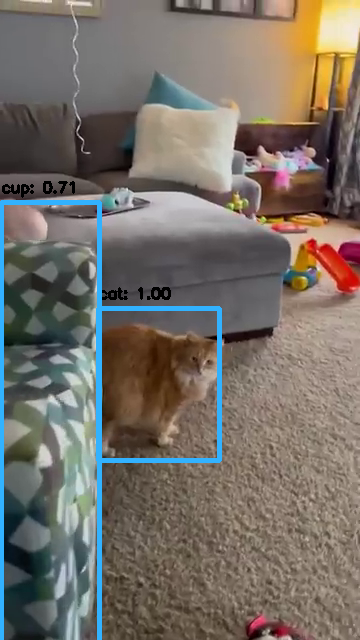

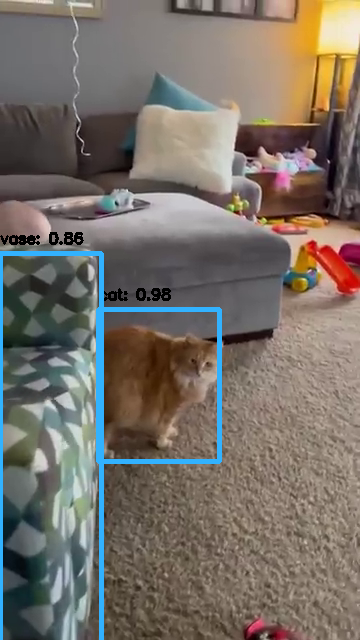

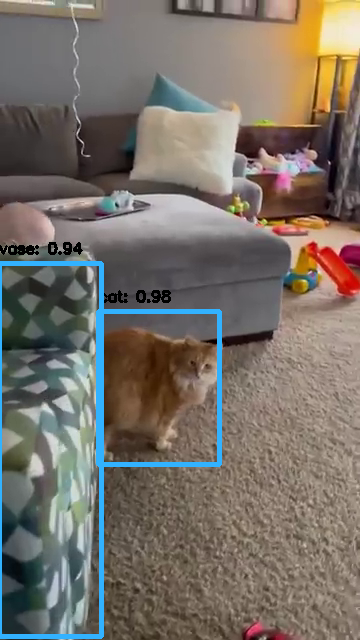

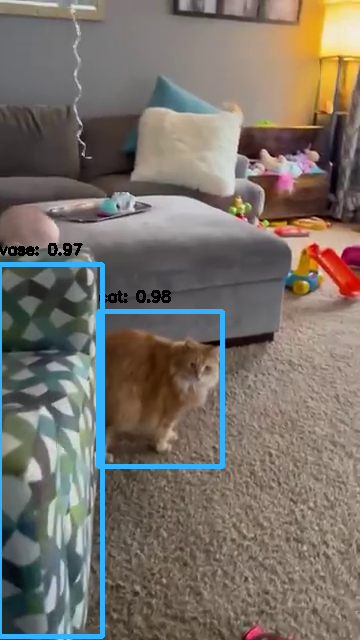

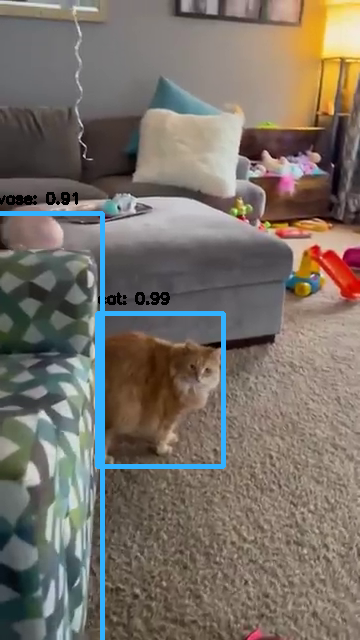

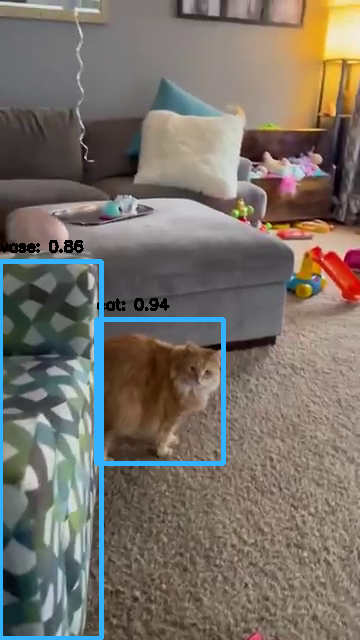

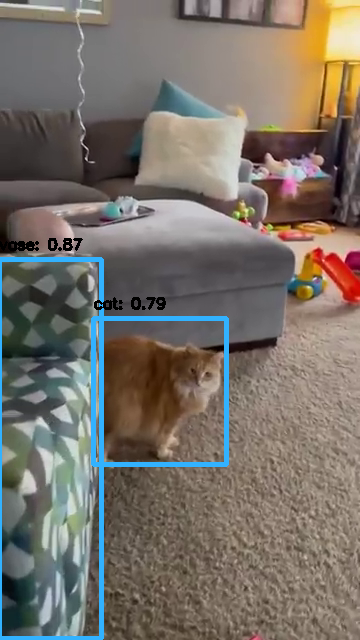

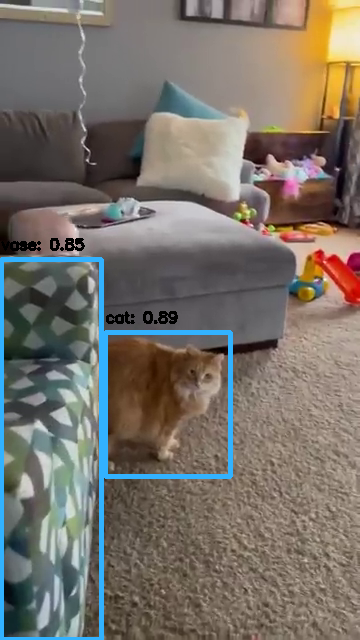

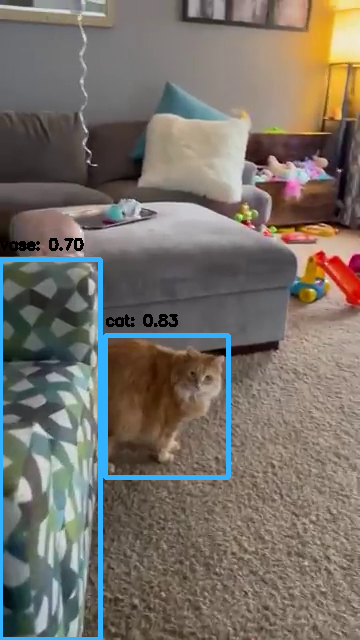

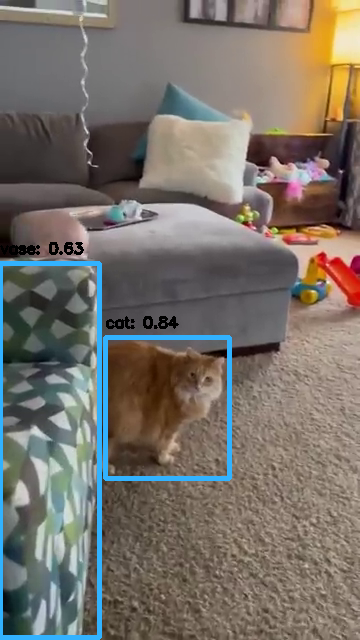

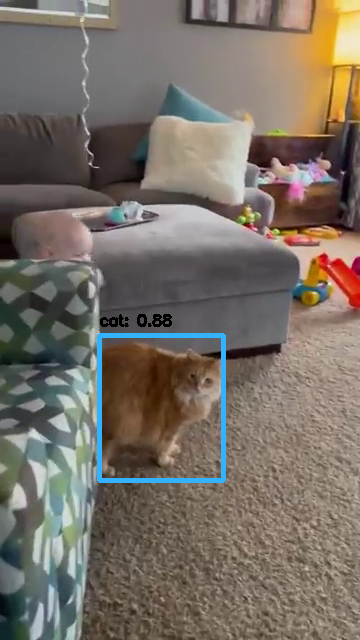

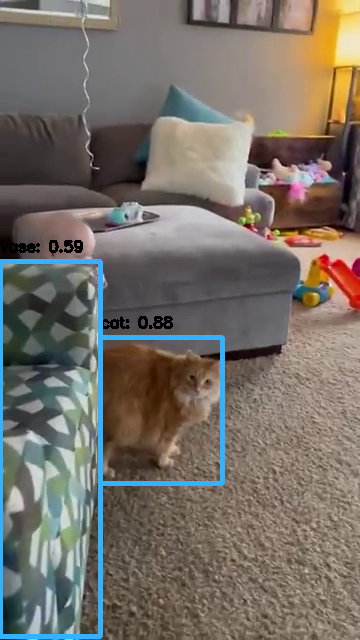

KeyboardInterrupt: 

In [31]:
detect_objects_in_video(video_path, net)